<a href="https://colab.research.google.com/github/salwaa-hub/tubes_machinelearning/blob/main/tubes_machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tugas Besar Machine Learning Semester 4 - Salwa Salsabila Daffa'atulhaq (4.33.23.2.25)**

1. Load & Parse Data

In [6]:
import pandas as pd

# Load dataset
df = pd.read_csv("weatherHistory.csv")

# Ubah kolom tanggal ke format datetime
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)

# Urutkan berdasarkan waktu
df.sort_values("Formatted Date", inplace=True)
df.reset_index(drop=True, inplace=True)

2. Praproses Data

In [7]:
# Drop kolom non-numerik
df.drop(columns=["Summary", "Precip Type", "Daily Summary"], inplace=True)

# Hapus missing values
df.dropna(inplace=True)

# Normalisasi fitur numerik
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=["Formatted Date"]))

# Gabungkan kembali ke DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled["Formatted Date"] = df["Formatted Date"].values
df_scaled = df_scaled[["Formatted Date"] + list(df_scaled.columns[:-1])]

3. EDA

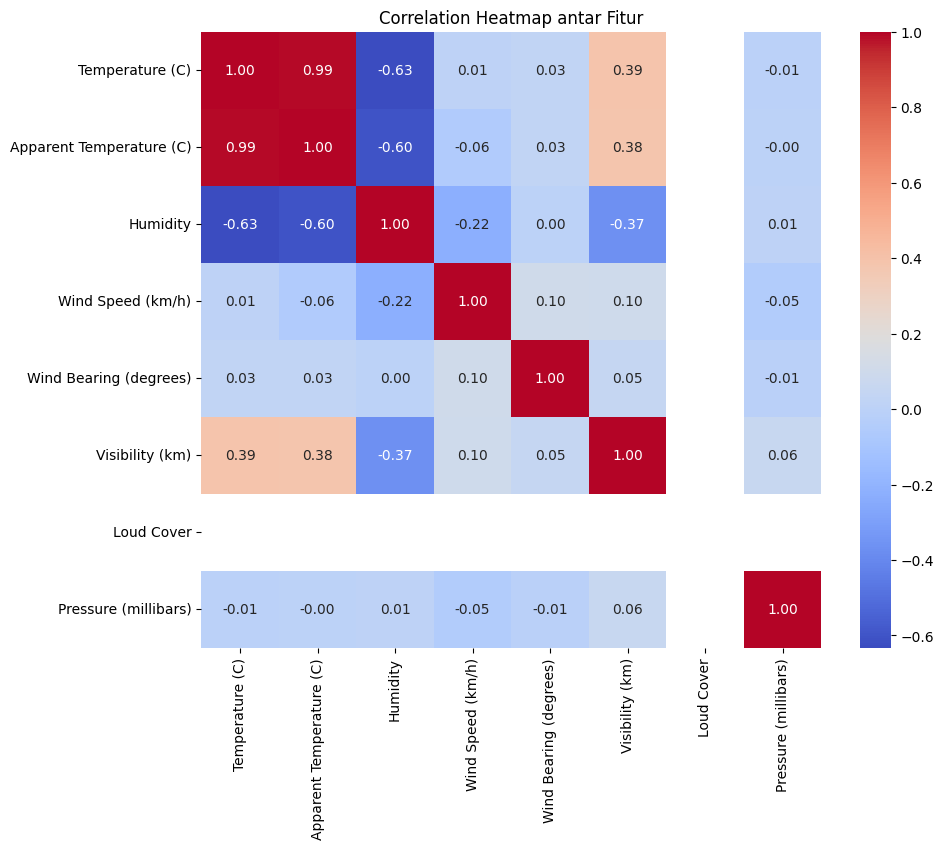

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=["Formatted Date"]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap antar Fitur")
plt.show()

4. Window Data untuk LSTM

In [9]:
import numpy as np

def create_lstm_dataset(data, look_back=24):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i][0])  # Kolom suhu = kolom 0
    return np.array(X), np.array(y)

look_back = 24
data_values = df_scaled.drop(columns=["Formatted Date"]).values
X, y = create_lstm_dataset(data_values, look_back)

5. Split Data Train/Test

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

6. Bangun dan Latih Model LSTM

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


965/965 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0090 - mae: 0.0532 - val_loss: 4.9700e-04 - val_mae: 0.0172
Epoch 2/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 6.0336e-04 - mae: 0.0188 - val_loss: 4.8908e-04 - val_mae: 0.0172
Epoch 3/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 4.9211e-04 - mae: 0.0167 - val_loss: 3.8750e-04 - val_mae: 0.0152
Epoch 4/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 4.3226e-04 - mae: 0.0156 - val_loss: 3.2299e-04 - val_mae: 0.0139
Epoch 5/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 4.0326e-04 - mae: 0.0147 - val_loss: 4.8299e-04 - val_mae: 0.0174
Epoch 6/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 3.9839e-04 - mae: 0.0146 - val_loss: 3.7239e-04 - val_mae: 0.0150
Epoch 7/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 3.8169e-04 - mae: 0.0143 - val_loss: 3.0434e-04 - val_mae: 0.0132
Epoch 8/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 3.5024e-04 - mae: 0.0135 - val_loss: 3.7538e-04 - val_mae

7. Simpan Model (.h5)

In [12]:
model.save("lstm_temperature_model.h5")

8. Inverse Transform ke Skala Celcius

In [13]:
# Prediksi
y_pred = model.predict(X_test)

# Siapkan array untuk inverse transform
y_pred_full = np.zeros((len(y_pred), X.shape[2]))
y_pred_full[:, 0] = y_pred[:, 0]
y_pred_celsius = scaler.inverse_transform(y_pred_full)[:, 0]

y_test_full = np.zeros((len(y_test), X.shape[2]))
y_test_full[:, 0] = y_test
y_test_celsius = scaler.inverse_transform(y_test_full)[:, 0]

603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


9. Evaluasi: RMSE & MAE dalam Celcius

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_celsius, y_pred_celsius)
rmse = np.sqrt(mean_squared_error(y_test_celsius, y_pred_celsius))

print(f"MAE  (°C) = {mae:.4f}")
print(f"RMSE (°C) = {rmse:.4f}")

MAE  (°C) = 0.6427
RMSE (°C) = 0.8756


10. Visualisasi Prediksi vs Aktual

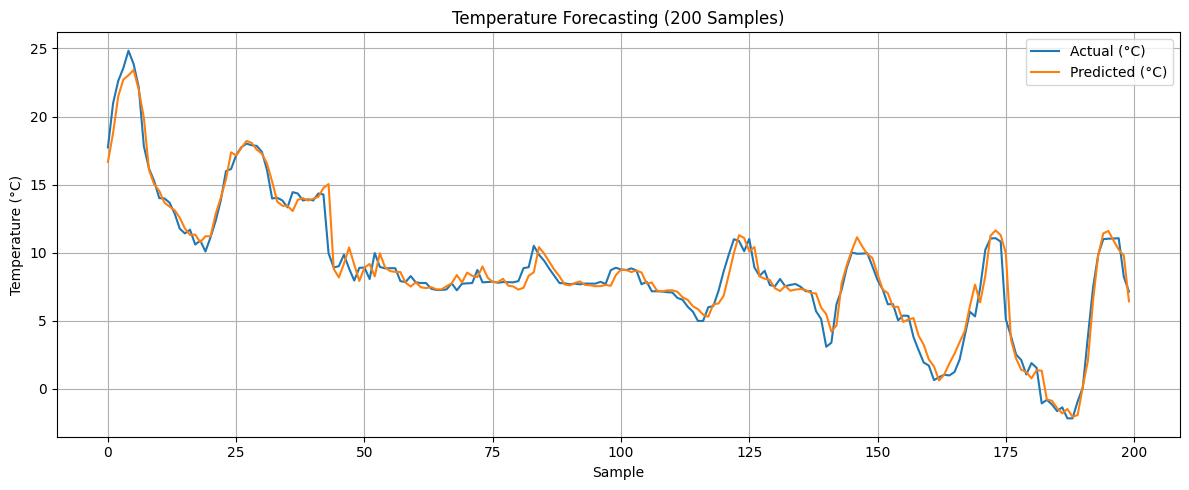

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_celsius[:200], label='Actual (°C)')
plt.plot(y_pred_celsius[:200], label='Predicted (°C)')
plt.title("Temperature Forecasting (200 Samples)")
plt.xlabel("Sample")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

11. Visualisasi Training History (Loss & MAE)

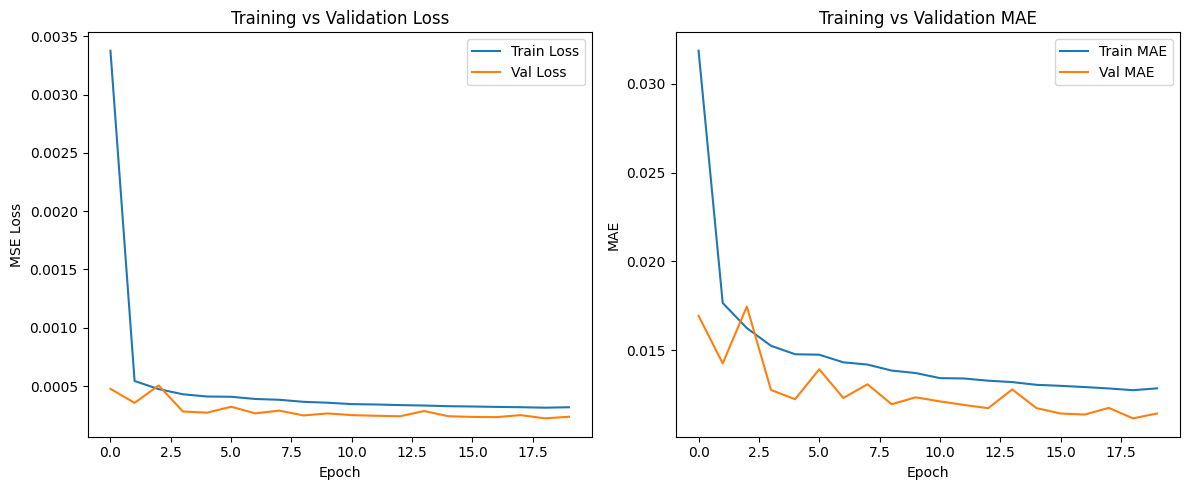

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

12. Visualisasi Distribusi Error

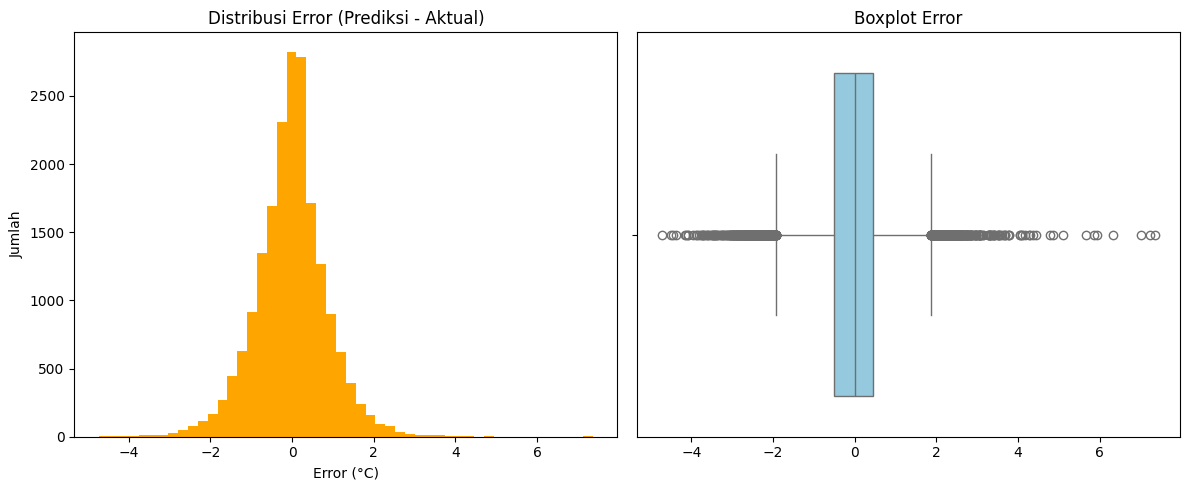

In [17]:
errors = y_pred_celsius - y_test_celsius

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, color='orange')
plt.title("Distribusi Error (Prediksi - Aktual)")
plt.xlabel("Error (°C)")
plt.ylabel("Jumlah")

plt.subplot(1, 2, 2)
sns.boxplot(x=errors, color='skyblue')
plt.title("Boxplot Error")

plt.tight_layout()
plt.show()